# Deep Q-Learning on Mario Bros
<hr>
This is a reinforcement learning project on implementing a deep q-network and training it to play the Atari 2600 version of Mario Bros. Below is the notebook documenting training, experiments done, etc.

Let's create the gym environment

In [1]:
pip install wandb

Note: you may need to restart the kernel to use updated packages.


In [2]:
# import environment dependencies
import gymnasium as gym
import ale_py
from ale_py import ALEInterface

# import saved model
import torch

# import model
from dqn import DQN

# import plotting
import matplotlib.pyplot as plt

# import wandb for logging
import wandb

# import rendering
from IPython import display
from PIL import Image
import time

Here is some starter code to play around with the environment and API - get a feel for what is happening with the API and the wrapper.

13
Box(0, 255, (210, 160, 3), uint8)
False
<class 'numpy.int64'>
<class 'gymnasium.spaces.box.Box'>
<class 'bool'>
render type: <class 'numpy.ndarray'>


A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


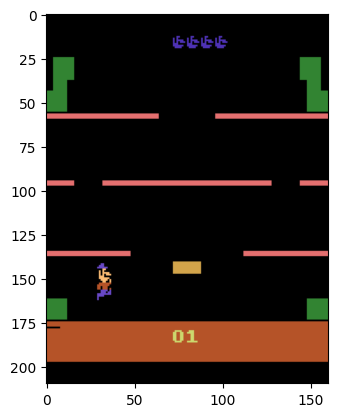

In [3]:
# let's create the environment to make sure it works
env = gym.make(
    'ALE/MarioBros-v5', 
    obs_type = 'rgb',
    render_mode = 'rgb_array'
)

obs, info = env.reset()
ACTION_SIZE = env.action_space.n
ACTIONS = env.action_space.sample()
OBSERVATIONS = env.observation_space
obs, reward, terminated, truncated, info = env.step(ACTIONS)

# print and log to see data types
print(ACTIONS)
print(OBSERVATIONS)
print(terminated)

print(type(ACTIONS))
print(type(OBSERVATIONS))
print(type(terminated))

# render the image
img = plt.imshow(env.render()) # only call this once
print('render type:', type(env.render()))

env.close()

In [4]:
# okay, let's actually start writing some code
rew_arr = [] # array holding rewards
episode_count = 100 # num episodes to train on

# instantiate the mario emulator gym
env = gym.make(
    'ALE/MarioBros-v5',
    obs_type = 'rgb',
    render_mode = 'rgb_array'
)

In [5]:
# instantiate the model
obs, info = env.reset()
in_channels = env.render().shape[2]

wandb.login()

# init wandb logging 
wandb.init(
    entity="zavierand-new-york-university",
    project='dqn-mario',
    config={
        'learning_rate': 1e-2,
        'architecture': 'DQN',
        'epochs': 100,
    },
)

# instantiate the model
dqn = DQN(env, in_channels, env.action_space.n)

# train the model
# dqn._train(env)

wandb: Currently logged in as: zavierand (zavierand-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


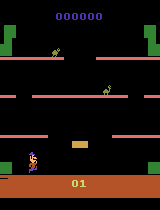

In [ ]:
# load the trained model
dqn.model.load_state_dict(torch.load('./dqn_trained.pt'))

# Evaluate the model's performance and capture frames
num_episodes = 10000
avg_reward, rewards, frames = dqn._eval(env, num_episodes=10000, render=True)

# Plot rewards per episode
plt.plot(rewards)
plt.title("Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

# Animate the model's performance for episodes that are a multiple of 1000
for frame in frames:
    display.display(Image.fromarray(frame))
    time.sleep(0.05)  # Adjust for speed of rendering
    #display.clear_output(wait=True)
